In [2]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [4]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x/1000, y/1000

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

In [5]:
edata = eddies['Eddy15'].iloc[10] #E22T5 #E17T3
t = extract_number(edata.name)

mcolor = 'r' if edata.Vort > 0 else 'c'
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    OW = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    ocean_time = dataset.variables['ocean_time'][:]
    
    previous_file_idx = file_idx

In [103]:
from skimage.metrics import structural_similarity as ssim

def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)

    def compare_matrices_ssim(matrix1, matrix2):
        data_range = matrix1.max() - matrix1.min()
        return ssim(matrix1, matrix2, data_range=data_range)

    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)

    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'Correlation'])
    best_shift = df.loc[df['Correlation'].idxmax()]

    return df, best_shift['Up'], best_shift['Right']

from shapely.geometry import Polygon
def calculate_centroid(xt, yt):
    if len(xt) == 0:
        return np.nan, np.nan
    polygon = Polygon(zip(xt, yt))
    centroid = polygon.centroid
    return centroid.x, centroid.y

def gaussian_vortex(a, b, i_shift, j_shift, amplitude=1, sigma=1):
    x = np.linspace(-1, 1, b)
    y = np.linspace(-1, 1, a)
    x, y = np.meshgrid(x, y)
    return amplitude * np.exp(-((x - j_shift)**2 + (y - i_shift)**2) / (2 * sigma**2))


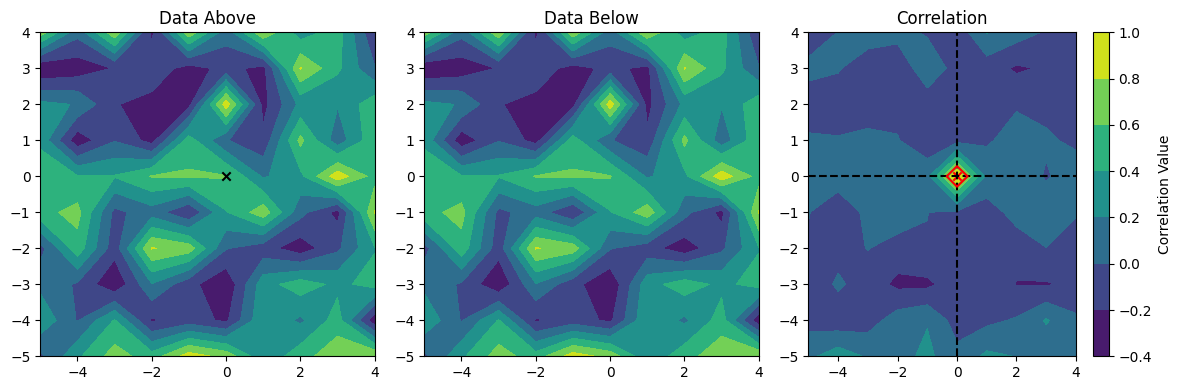

In [152]:
a, b = 10, 10
Data_abv = np.random.randint(0, 100, (10, 10))
Data_blw = Data_abv

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)

xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].scatter(iR, iU, marker='x', color='k')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')

# Display the plots
plt.tight_layout()
plt.show()

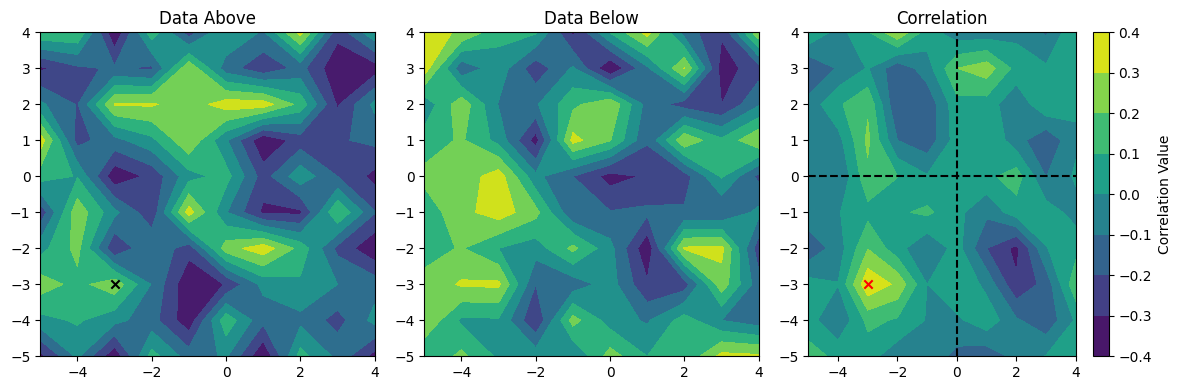

In [162]:
a, b = 10, 10
Data_abv = np.random.randint(0, 100, (10, 10))
Data_blw = np.random.randint(0, 100, (10, 10))

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)

xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].scatter(iR, iU, marker='x', color='k')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')

# Display the plots
plt.tight_layout()
plt.show()

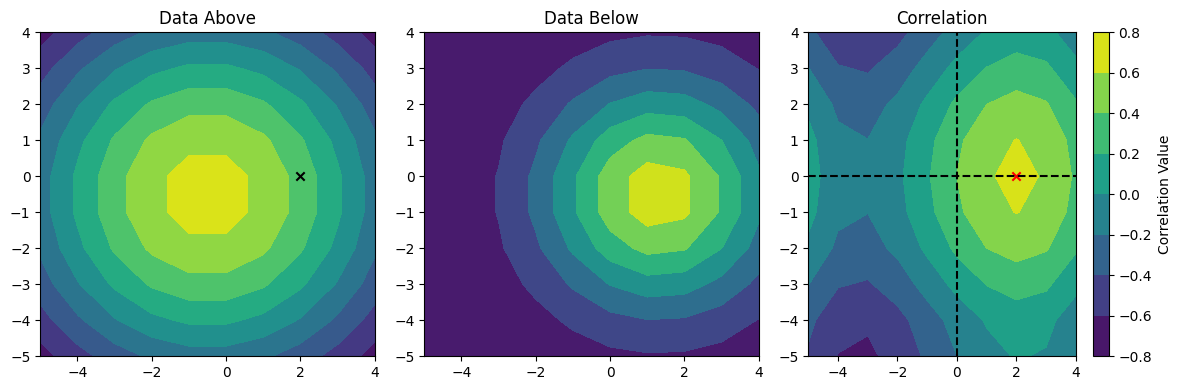

In [157]:
a, b = 10, 10
Data_abv = gaussian_vortex(a, b, 0, 0, amplitude=1, sigma=1)
Data_blw = gaussian_vortex(a, b, 0, .4, amplitude=1, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].scatter(iR, iU, marker='x', color='k')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

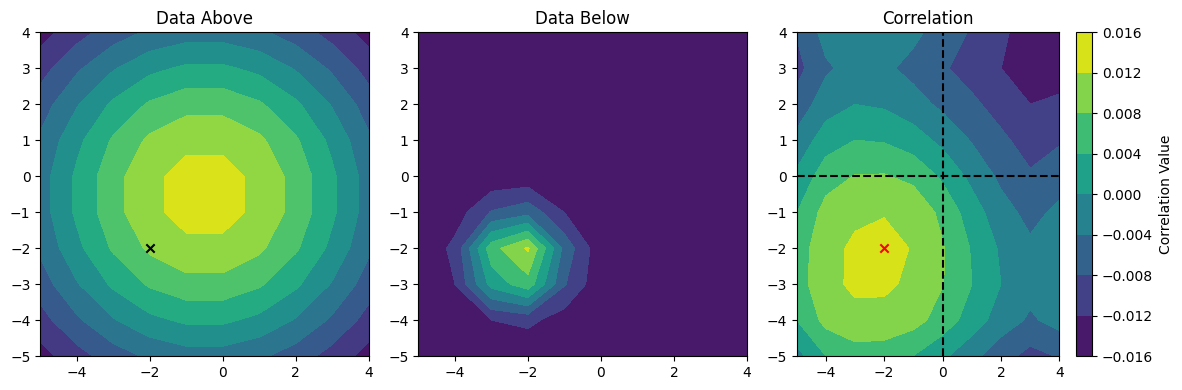

In [156]:
a, b = 10, 10
Data_abv = gaussian_vortex(a, b, 0, 0, amplitude=1, sigma=1)
Data_blw = gaussian_vortex(a, b, -.4, -.4, amplitude=.2, sigma=.2)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].scatter(iR, iU, marker='x', color='k')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

In [139]:
def annulus_vortex(a, b, inner_radius, outer_radius, i_shift, j_shift, amplitude=1, sigma=1):
    x = np.linspace(-1, 1, b)
    y = np.linspace(-1, 1, a)
    x, y = np.meshgrid(x, y)
    distance = np.sqrt((x - j_shift)**2 + (y - i_shift)**2)
    annulus = np.where((distance >= inner_radius) & (distance <= outer_radius),
                       amplitude * np.exp(-((distance)**2) / (2 * sigma**2)), 0)
    return annulus

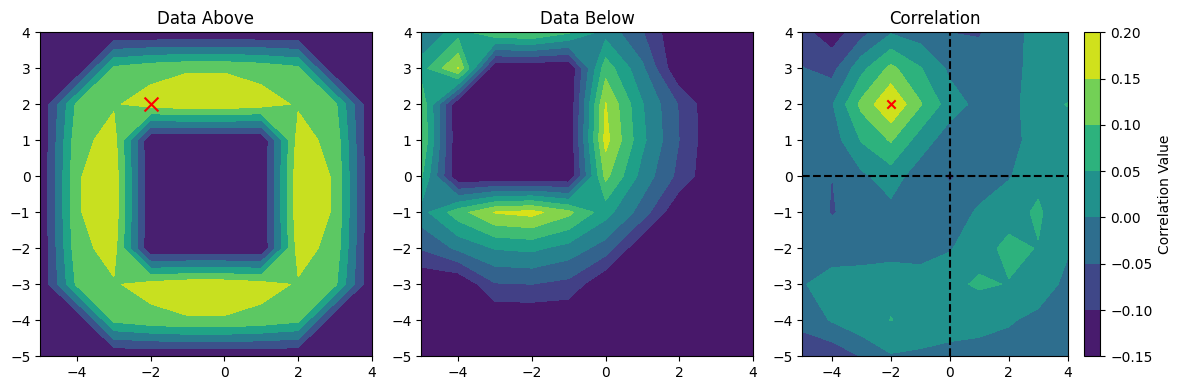

In [159]:
a, b = 10, 10
Data_abv = annulus_vortex(a, b, .5, 1, 0, 0, amplitude=1, sigma=1)
Data_blw = annulus_vortex(a, b, .5, 1, .4, -.4, amplitude=.5, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].scatter(iR, iU, marker='x', color='r', s=100)
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

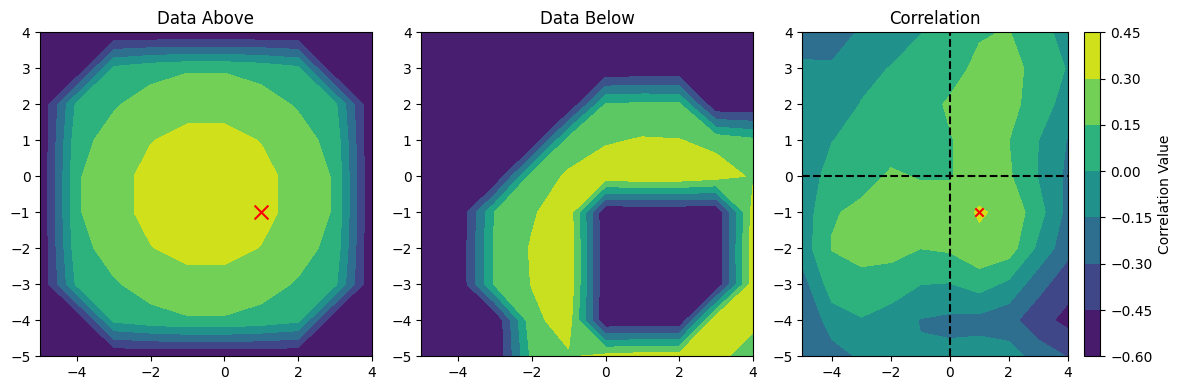

In [145]:
a, b = 10, 10
Data_abv = annulus_vortex(a, b, .1, 1, 0, 0, amplitude=1, sigma=1)
Data_blw = annulus_vortex(a, b, .5, 1, -.4, .4, amplitude=1, sigma=1)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].scatter(iR, iU, marker='x', color='r', s=100)
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

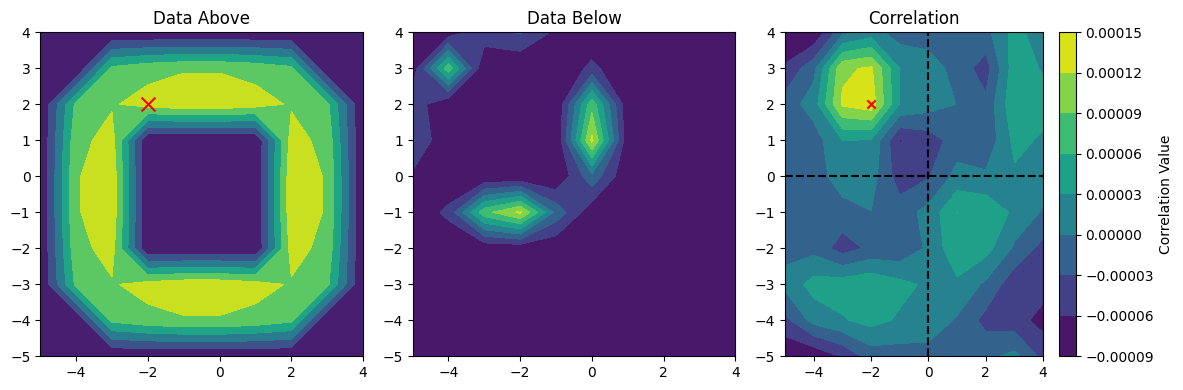

In [161]:
a, b = 10, 10
Data_abv = annulus_vortex(a, b, .5, 1, 0, 0, amplitude=1, sigma=1)
Data_blw = annulus_vortex(a, b, .5, 1, .4, -.4, amplitude=.5, sigma=.2)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].scatter(iR, iU, marker='x', color='r', s=100)
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()